<a href="https://colab.research.google.com/github/womaro/SimlationOfQubit/blob/main/SIC-POVM%20Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from scipy.spatial import distance

def heaviside(z):
    """
    Implementacja funkcji Heaviside H(z).

    Args:
        z: Wartość wejściowa

    Returns:
        1 jeśli z ≥ 0, 0 jeśli z < 0
    """
    return 1 if z >= 0 else 0

def generate_random_sphere_points(n):
    """
    Generates n points randomly distributed on a unit sphere.

    Args:
        n: Number of points to generate

    Returns:
        Numpy array of shape (n, 3) containing point coordinates
    """
    print(f"Generating {n} points randomly on a unit sphere...")
    print(f"Generowanie {n} punktów losowo na sferze jednostkowej...")

    start_time = time.time()

    # Truly random method using gaussian distribution
    # This avoids bias towards poles that occurs with naive angle sampling
    points = np.random.randn(n, 3)
    # Normalize to unit sphere
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]

    end_time = time.time()
    print(f"Generation completed in {end_time - start_time:.2f} seconds.")
    print(f"Generowanie zakończone w {end_time - start_time:.2f} sekund.")

    return points

def generate_random_quantum_state():
    """
    Generates a random quantum state represented as a point on the Bloch sphere.

    Returns:
        Numpy array of shape (3,) containing the Bloch vector coordinates
    """
    # Generate random vector in 3D space
    rho = np.random.randn(3)
    # Normalize to unit sphere
    rho = rho / np.linalg.norm(rho)

    print(f"Generated random quantum state ρ = [{rho[0]:.6f}, {rho[1]:.6f}, {rho[2]:.6f}]")
    print(f"Wygenerowano losowy stan kwantowy ρ = [{rho[0]:.6f}, {rho[1]:.6f}, {rho[2]:.6f}]")

    # Convert to spherical coordinates and quantum notation
    theta, phi = cartesian_to_spherical(rho)
    ket_notation = bloch_to_ket(rho)

    print(f"Spherical coordinates: θ = {theta:.4f}°, φ = {phi:.4f}°")
    print(f"State in ket notation: {ket_notation}")

    return rho

def select_random_points(points, num_select=2):
    """
    Randomly selects a specified number of points from the given array.

    Args:
        points: Array of points
        num_select: Number of points to select

    Returns:
        Array of selected points
    """
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def cartesian_to_spherical(point):
    """
    Converts a point from Cartesian (x,y,z) to spherical (theta, phi) coordinates.

    Args:
        point: Array of Cartesian coordinates [x, y, z]

    Returns:
        Tuple (theta, phi) in degrees where:
        - theta is the angle from the positive z-axis (0 to 180 degrees)
        - phi is the angle in the xy plane from the positive x-axis (0 to 360 degrees)
    """
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere

    # Calculate theta (polar angle from z-axis)
    theta = np.arccos(z / r) * 180 / np.pi

    # Calculate phi (azimuthal angle in xy-plane)
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range

    return theta, phi

def bloch_to_ket(point):
    """
    Converts a point on the Bloch sphere to quantum state in ket notation.

    Args:
        point: Array of Cartesian coordinates [x, y, z]

    Returns:
        String representation of quantum state in ket notation
    """
    x, y, z = point

    # Calculate theta and phi
    theta = np.arccos(z)
    phi = np.arctan2(y, x)

    # Calculate coefficients
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Format complex numbers nicely
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        # Handle the phase factor
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            # Phase is π or -π
            beta_str = f"-{beta_mag:.4f}"
        else:
            # Express as a complex number
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    # Create the ket notation - using ASCII characters for compatibility
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def compute_transformed_vectors(selected_points, quantum_state):
    """
    Oblicza przekształcone wektory lambda' na podstawie stanu kwantowego i funkcji Heaviside.

    Args:
        selected_points: Lista wektorów lambda
        quantum_state: Wektor stanu kwantowego rho

    Returns:
        Lista przekształconych wektorów lambda' zgodnie z protokołem
    """
    transformed_points = []

    for i, point in enumerate(selected_points):
        # Obliczenie wartości c_i = H(rho⋅lambda_i)
        c_i = heaviside(np.dot(quantum_state, point))

        # Przekształcenie wektora lambda_i na lambda_i'
        # lambda_i' = lambda_i gdy c_i = 1
        # lambda_i' = -lambda_i gdy c_i = 0
        lambda_prime = point if c_i == 1 else -point

        transformed_points.append({
            'original': point,
            'transformed': lambda_prime,
            'c_i': c_i
        })

    return transformed_points

def visualize_protocol_points_plotly(all_points, selected_points, transformed_points, quantum_state, title="Visualization of Points on Unit Sphere with Protocol Steps"):
    """
    Visualizes points on a unit sphere including the protocol steps using Plotly.

    Args:
        all_points: Array of all points
        selected_points: Array of selected points (lambda1 and lambda2)
        transformed_points: List of dictionaries with transformed points info
        quantum_state: The quantum state vector (rho)
        title: Title for the visualization
    """
    # Creating the sphere grid
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Creating the plot
    fig = go.Figure()

    # Adding the sphere grid
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Unit Sphere / Sfera Jednostkowa'
    ))

    # Add axes
    axis_length = 1.2  # Extend beyond the sphere

    # X-axis (red)
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[axis_length], y=[0], z=[0],
        mode='text',
        text=['X'],
        textposition="middle right",
        textfont=dict(color='red', size=16),
        showlegend=False
    ))

    # Y-axis (green)
    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[0], y=[axis_length], z=[0],
        mode='text',
        text=['Y'],
        textposition="middle right",
        textfont=dict(color='green', size=16),
        showlegend=False
    ))

    # Z-axis (blue)
    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[axis_length],
        mode='text',
        text=['Z'],
        textposition="top center",
        textfont=dict(color='blue', size=16),
        showlegend=False
    ))

    # Sample a subset of points for display if there are too many
    display_points = all_points
    if len(all_points) > 2000:
        indices = np.random.choice(len(all_points), 2000, replace=False)
        display_points = all_points[indices]

    # Adding all points
    fig.add_trace(go.Scatter3d(
        x=display_points[:, 0], y=display_points[:, 1], z=display_points[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.2
        ),
        name='Random Points / Losowe Punkty'
    ))

    # Adding quantum state (rho)
    theta_rho, phi_rho = cartesian_to_spherical(quantum_state)
    ket_notation = bloch_to_ket(quantum_state)

    hover_text = f"ρ<br>x: {quantum_state[0]:.4f}, y: {quantum_state[1]:.4f}, z: {quantum_state[2]:.4f}<br>" + \
                 f"θ: {theta_rho:.2f}°, φ: {phi_rho:.2f}°<br>{ket_notation}"

    # Dodanie przezroczystej półsfery reprezentującej przestrzeń, w której H(ρ⋅λ) = 1
    theta_hemi = np.linspace(0, np.pi, 50)
    phi_hemi = np.linspace(0, 2*np.pi, 100)
    theta_grid_hemi, phi_grid_hemi = np.meshgrid(theta_hemi, phi_hemi)

    x_hemi = np.sin(theta_grid_hemi) * np.cos(phi_grid_hemi)
    y_hemi = np.sin(theta_grid_hemi) * np.sin(phi_grid_hemi)
    z_hemi = np.cos(theta_grid_hemi)

    # Obliczamy wartości w siatce
    hemi_points = np.stack([x_hemi.flatten(), y_hemi.flatten(), z_hemi.flatten()], axis=1)
    dot_products = np.dot(hemi_points, quantum_state)
    mask = dot_products >= 0

    x_hemi_filtered = np.reshape(hemi_points[mask, 0], (-1, 1))
    y_hemi_filtered = np.reshape(hemi_points[mask, 1], (-1, 1))
    z_hemi_filtered = np.reshape(hemi_points[mask, 2], (-1, 1))

    fig.add_trace(go.Scatter3d(
        x=x_hemi_filtered[:, 0], y=y_hemi_filtered[:, 0], z=z_hemi_filtered[:, 0],
        mode='markers',
        marker=dict(
            size=2,
            color='yellow',
            opacity=0.1
        ),
        name='H(ρ⋅λ) = 1 Region'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(
                color='black',
                width=2
            )
        ),
        text=['ρ'],
        hovertext=[hover_text],
        hoverinfo='text',
        textposition="top center",
        name='Quantum State / Stan Kwantowy'
    ))

    # Line from center to quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(
            color='gold',
            width=4,
            dash='solid'
        ),
        showlegend=False
    ))

    # Adding original and transformed points
    colors = ['red', 'green']

    for i, point_info in enumerate(transformed_points):
        original_point = point_info['original']
        transformed_point = point_info['transformed']
        c_i = point_info['c_i']

        theta_orig, phi_orig = cartesian_to_spherical(original_point)
        theta_trans, phi_trans = cartesian_to_spherical(transformed_point)

        hover_orig = f"λ{i+1}<br>x: {original_point[0]:.4f}, y: {original_point[1]:.4f}, z: {original_point[2]:.4f}<br>" + \
                     f"θ: {theta_orig:.2f}°, φ: {phi_orig:.2f}°<br>c{i+1} = H(ρ⋅λ{i+1}) = {c_i}"

        hover_trans = f"λ{i+1}'<br>x: {transformed_point[0]:.4f}, y: {transformed_point[1]:.4f}, z: {transformed_point[2]:.4f}<br>" + \
                      f"θ: {theta_trans:.2f}°, φ: {phi_trans:.2f}°<br>λ{i+1}' = {'' if c_i == 1 else '-'}λ{i+1}"

        # Dodajemy oryginalny punkt
        fig.add_trace(go.Scatter3d(
            x=[original_point[0]], y=[original_point[1]], z=[original_point[2]],
            mode='markers+text',
            marker=dict(
                size=8,
                color=colors[i]
            ),
            text=[f'λ{i+1}'],
            hovertext=[hover_orig],
            hoverinfo='text',
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Dodajemy przekształcony punkt
        if np.array_equal(original_point, transformed_point):
            # Jeśli λ = λ' (nie ma zmiany), to zaznaczamy to specjalnym markerem
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',  # 'star' nie jest obsługiwany w scatter3d, używamy 'diamond' zamiast
                    line=dict(color='black', width=2)
                ),
                text=['λ = λ\''],
                hovertext=[f"λ{i+1} = λ{i+1}' (no change / bez zmiany)"],
                hoverinfo='text',
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # Jeśli λ ≠ λ' (jest zmiana), dodajemy nowy punkt
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                hovertext=[hover_trans],
                hoverinfo='text',
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

        # Line from center to original point
        fig.add_trace(go.Scatter3d(
            x=[0, original_point[0]], y=[0, original_point[1]], z=[0, original_point[2]],
            mode='lines',
            line=dict(
                color=colors[i],
                width=3,
                dash='dash'
            ),
            showlegend=False
        ))

        # Jeśli jest zmiana, dodajemy linię do przekształconego punktu
        if not np.array_equal(original_point, transformed_point):
            fig.add_trace(go.Scatter3d(
                x=[0, transformed_point[0]], y=[0, transformed_point[1]], z=[0, transformed_point[2]],
                mode='lines',
                line=dict(
                    color=colors[i],
                    width=3,
                    dash='dot'
                ),
                showlegend=False
            ))

    # Layout configuration
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14
        )
    )

    fig.show()

def calculate_angles_with_rho(points, rho):
    """
    Calculates angles between each point and the quantum state rho.

    Args:
        points: Array of points
        rho: Quantum state vector

    Returns:
        Array of angles in degrees
    """
    # Calculate dot products
    dot_products = np.dot(points, rho)

    # Convert to angles (in degrees)
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0)) * 180 / np.pi

    return angles

def generate_and_select_points(n=1000, visualization=True, analyze=True):
    """
    Main function to generate points, select lambda vectors, and generate quantum state.

    Args:
        n: Number of points to generate
        visualization: Whether to visualize the points
        analyze: Whether to analyze uniformity

    Returns:
        Tuple (all_points, selected_points, quantum_state)
    """
    # Generate quantum state
    quantum_state = generate_random_quantum_state()

    # Generate points
    all_points = generate_random_sphere_points(n)

    # Select random points
    selected_points = select_random_points(all_points)

    # Calculate angles between points and quantum state
    angles = calculate_angles_with_rho(selected_points, quantum_state)

    # Print information about selected points
    print("\nSelected points (lambda1, lambda2):")
    print("Wybrane punkty (lambda1, lambda2):")
    for i, point in enumerate(selected_points):
        theta, phi = cartesian_to_spherical(point)
        print(f"λ{i+1} = [{point[0]:.6f}, {point[1]:.6f}, {point[2]:.6f}]")
        print(f"Spherical coordinates: θ = {theta:.2f}°, φ = {phi:.2f}°")
        print(f"Angle with ρ: {angles[i]:.2f}°")

    # Compute transformed points
    transformed_points = compute_transformed_vectors(selected_points, quantum_state)

    # Print information about transformed points
    print("\nTransformed points (lambda1', lambda2'):")
    print("Przekształcone punkty (lambda1', lambda2'):")
    for i, point_info in enumerate(transformed_points):
        original = point_info['original']
        transformed = point_info['transformed']
        c_i = point_info['c_i']

        # Calculate angles
        dot_product = np.dot(quantum_state, original)

        print(f"c{i+1} = H(ρ⋅λ{i+1}) = H({dot_product:.4f}) = {c_i}")

        if c_i == 1:
            print(f"λ{i+1}' = λ{i+1} (no change / bez zmiany)")
        else:
            print(f"λ{i+1}' = -λ{i+1}")

        print(f"λ{i+1}' = [{transformed[0]:.6f}, {transformed[1]:.6f}, {transformed[2]:.6f}]")

    # Visualization
    if visualization:
        visualize_protocol_points_plotly(
            all_points, selected_points, transformed_points, quantum_state,
            "Quantum State Protocol Visualization with Transformed Vectors"
        )

    return all_points, selected_points, quantum_state, transformed_points

def generate_protocol_simulation(n_points=1000):
    """
    Generates inputs for the quantum protocol and simulates the first steps.

    Args:
        n_points: Number of points to generate

    Returns:
        Dictionary with protocol simulation data
    """
    all_points, selected_points, quantum_state, transformed_points = generate_and_select_points(n_points)

    # Calculate probabilities for POVM elements
    # This is a simple example with a projective measurement
    p1 = 0.7
    p2 = 0.3
    y1 = np.array([0.0, 0.0, 1.0])  # |0>
    y2 = np.array([0.0, 0.0, -1.0]) # |1>

    # Calculate quantum probabilities using Born's rule
    prob1 = p1 * (1 + np.dot(quantum_state, y1))
    prob2 = p2 * (1 + np.dot(quantum_state, y2))

    # Normalize
    total = prob1 + prob2
    prob1 /= total
    prob2 /= total

    # Get quantum state in ket notation
    ket_notation = bloch_to_ket(quantum_state)

    print("\nProtokół symulacji kwantowej:")
    print(f"Quantum state ρ = {quantum_state} → |ψ> = {ket_notation}")

    for i, point_info in enumerate(transformed_points):
        print(f"Bit {i+1}: c{i+1} = {point_info['c_i']}")

    print(f"POVM elements: p₁ = {p1}, y₁ = {y1}, p₂ = {p2}, y₂ = {y2}")
    print(f"Quantum probabilities: P(1) = {prob1:.4f}, P(2) = {prob2:.4f}")

    # Implementation of protocol steps
    print("\nImplementacja kolejnych kroków protokołu:")
    print("1. Alice i Bob współdzielą dwa wektory jednostkowe λ₁, λ₂ ∈ ℝ³")
    print("2. Alice zamiast wysyłać kubit ρ oblicza dwa bity:")
    print(f"   c₁ = H(ρ⋅λ₁) = {transformed_points[0]['c_i']}")
    print(f"   c₂ = H(ρ⋅λ₂) = {transformed_points[1]['c_i']}")
    print("3. Bob odwraca każdy wektor λᵢ, gdy odpowiadający bit cᵢ wynosi 0:")

    # Formatowanie przekształconych wektorów
    for i, point_info in enumerate(transformed_points):
        if point_info['c_i'] == 1:
            print(f"   λ{i+1}' = λ{i+1} (bez zmiany, c{i+1}=1)")
        else:
            print(f"   λ{i+1}' = -λ{i+1} (odwrócony, c{i+1}=0)")

    return {
        'rho': quantum_state,
        'rho_ket': ket_notation,
        'lambda': [point_info['original'] for point_info in transformed_points],
        'lambda_prime': [point_info['transformed'] for point_info in transformed_points],
        'c_bits': [point_info['c_i'] for point_info in transformed_points],
        'povm': {
            1: (p1, y1),
            2: (p2, y2)
        },
        'quantum_probs': {
            1: prob1,
            2: prob2
        }
    }

def analyze_point_coordinates_distribution(all_points):
    """
    Analizuje rozkład współrzędnych x, y, z wygenerowanych punktów.

    Args:
        all_points: Tablica wszystkich punktów (n x 3)
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import numpy as np

    # Wydzielenie współrzędnych x, y, z
    x_coords = all_points[:, 0]
    y_coords = all_points[:, 1]
    z_coords = all_points[:, 2]

    # Tworzenie wykresu
    fig = make_subplots(rows=1, cols=3, subplot_titles=['Współrzędne X', 'Współrzędne Y', 'Współrzędne Z'])

    # Histogram współrzędnych X
    fig.add_trace(
        go.Histogram(
            x=x_coords,
            nbinsx=30,
            marker_color='red',
            opacity=0.7,
            name='Współrzędne X'
        ),
        row=1, col=1
    )

    # Histogram współrzędnych Y
    fig.add_trace(
        go.Histogram(
            x=y_coords,
            nbinsx=30,
            marker_color='green',
            opacity=0.7,
            name='Współrzędne Y'
        ),
        row=1, col=2
    )

    # Histogram współrzędnych Z
    fig.add_trace(
        go.Histogram(
            x=z_coords,
            nbinsx=30,
            marker_color='blue',
            opacity=0.7,
            name='Współrzędne Z'
        ),
        row=1, col=3
    )

    # Dodanie linii teoretycznej rozkładu dla punktów na sferze jednostkowej
    x = np.linspace(-1, 1, 100)
    y = np.sqrt(1 - x**2) * (len(all_points)/60)  # Skalowanie dla porównania z histogramem

    for i in range(1, 4):
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode='lines',
                line=dict(color='black', dash='dash', width=2),
                name='Teoretyczny rozkład' if i == 1 else None,
                showlegend=i == 1
            ),
            row=1, col=i
        )

    # Konfiguracja osi
    for i in range(1, 4):
        fig.update_xaxes(title_text=f"Współrzędna {'X' if i==1 else 'Y' if i==2 else 'Z'}", range=[-1.1, 1.1], row=1, col=i)
        fig.update_yaxes(title_text="Liczba punktów", row=1, col=i)

    # Konfiguracja całego wykresu
    fig.update_layout(
        title_text='Rozkład współrzędnych x, y, z wygenerowanych punktów na sferze jednostkowej',
        height=500,
        width=1200,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    fig.show()

    # Pokazanie statystyk
    print("Statystyki rozkładu współrzędnych:")
    print(f"Średnia X: {np.mean(x_coords):.4f}, Odchylenie std: {np.std(x_coords):.4f}")
    print(f"Średnia Y: {np.mean(y_coords):.4f}, Odchylenie std: {np.std(y_coords):.4f}")
    print(f"Średnia Z: {np.mean(z_coords):.4f}, Odchylenie std: {np.std(z_coords):.4f}")

    # Test Kołmogorowa-Smirnowa dla porównania z teoretycznym rozkładem
    from scipy import stats

    # Dla równomiernego rozkładu na sferze współrzędne powinny być w przybliżeniu
    # zgodne z określonym rozkładem teoretycznym (nie równomiernym)
    x_theory = np.random.normal(0, 1/np.sqrt(3), 10000)
    y_theory = np.random.normal(0, 1/np.sqrt(3), 10000)
    z_theory = np.random.normal(0, 1/np.sqrt(3), 10000)

    # Normalizacja do sfery jednostkowej
    norms = np.sqrt(x_theory**2 + y_theory**2 + z_theory**2)
    x_theory /= norms
    y_theory /= norms
    z_theory /= norms

    ks_x = stats.ks_2samp(x_coords, x_theory)
    ks_y = stats.ks_2samp(y_coords, y_theory)
    ks_z = stats.ks_2samp(z_coords, z_theory)

    print("\nTest Kołmogorowa-Smirnowa (porównanie z rozkładem teoretycznym):")
    print(f"Współrzędne X: statystyka={ks_x.statistic:.4f}, p-wartość={ks_x.pvalue:.4f}")
    print(f"Współrzędne Y: statystyka={ks_y.statistic:.4f}, p-wartość={ks_y.pvalue:.4f}")
    print(f"Współrzędne Z: statystyka={ks_z.statistic:.4f}, p-wartość={ks_z.pvalue:.4f}")

    if min(ks_x.pvalue, ks_y.pvalue, ks_z.pvalue) > 0.05:
        print("Rozkład punktów na sferze jest zgodny z oczekiwanym rozkładem jednorodnym (p > 0.05)")
    else:
        print("Rozkład punktów może odbiegać od oczekiwanego rozkładu jednorodnego (p ≤ 0.05)")

    return

def generate_and_select_points_with_histograms(n=1000, visualization=True, analyze=True):
    """
    Rozszerzona funkcja generująca punkty, wybierająca wektory lambda i generująca stan kwantowy,
    a także tworząca histogramy.

    Args:
        n: Liczba punktów do wygenerowania
        visualization: Czy wizualizować punkty
        analyze: Czy analizować jednorodność

    Returns:
        Tuple (all_points, selected_points, quantum_state, transformed_points)
    """
    all_points, selected_points, quantum_state, transformed_points = generate_and_select_points(n, visualization, analyze)

    # Generuj histogramy rozkładu współrzędnych
    analyze_point_coordinates_distribution(all_points)

    return all_points, selected_points, quantum_state, transformed_points

def generate_protocol_simulation_with_histograms(n_points=1000):
    """
    Rozszerzona funkcja generująca dane wejściowe do protokołu kwantowego i symulująca pierwsze kroki,
    z dodanymi histogramami.

    Args:
        n_points: Liczba punktów do wygenerowania

    Returns:
        Słownik z danymi symulacji protokołu
    """
    all_points, selected_points, quantum_state, transformed_points = generate_and_select_points_with_histograms(n_points)

    # Calculate probabilities for POVM elements
    # This is a simple example with a projective measurement
    p1 = 0.7
    p2 = 0.3
    y1 = np.array([0.0, 0.0, 1.0])  # |0>
    y2 = np.array([0.0, 0.0, -1.0]) # |1>

    # Calculate quantum probabilities using Born's rule
    prob1 = p1 * (1 + np.dot(quantum_state, y1))
    prob2 = p2 * (1 + np.dot(quantum_state, y2))

    # Normalize
    total = prob1 + prob2
    prob1 /= total
    prob2 /= total

    # Get quantum state in ket notation
    ket_notation = bloch_to_ket(quantum_state)

    print("\nProtokół symulacji kwantowej:")
    print(f"Quantum state ρ = {quantum_state} → |ψ> = {ket_notation}")

    for i, point_info in enumerate(transformed_points):
        print(f"Bit {i+1}: c{i+1} = {point_info['c_i']}")

    print(f"POVM elements: p₁ = {p1}, y₁ = {y1}, p₂ = {p2}, y₂ = {y2}")
    print(f"Quantum probabilities: P(1) = {prob1:.4f}, P(2) = {prob2:.4f}")

    # Implementation of protocol steps
    print("\nImplementacja kolejnych kroków protokołu:")
    print("1. Alice i Bob współdzielą dwa wektory jednostkowe λ₁, λ₂ ∈ ℝ³")
    print("2. Alice zamiast wysyłać kubit ρ oblicza dwa bity:")
    print(f"   c₁ = H(ρ⋅λ₁) = {transformed_points[0]['c_i']}")
    print(f"   c₂ = H(ρ⋅λ₂) = {transformed_points[1]['c_i']}")
    print("3. Bob odwraca każdy wektor λᵢ, gdy odpowiadający bit cᵢ wynosi 0:")

    # Formatowanie przekształconych wektorów
    for i, point_info in enumerate(transformed_points):
        if point_info['c_i'] == 1:
            print(f"   λ{i+1}' = λ{i+1} (bez zmiany, c{i+1}=1)")
        else:
            print(f"   λ{i+1}' = -λ{i+1} (odwrócony, c{i+1}=0)")

    return {
        'rho': quantum_state,
        'rho_ket': ket_notation,
        'lambda': [point_info['original'] for point_info in transformed_points],
        'lambda_prime': [point_info['transformed'] for point_info in transformed_points],
        'c_bits': [point_info['c_i'] for point_info in transformed_points],
        'povm': {
            1: (p1, y1),
            2: (p2, y2)
        },
        'quantum_probs': {
            1: prob1,
            2: prob2
        }
    }

if __name__ == "__main__":
    print("=== Symulacja Protokołu Klasycznego Kosztu Transmisji Kubitu ===")
    print("=== Classical Cost of Transmitting a Qubit Protocol Simulation ===")
    print("=============================================================")

    try:
        n_points = int(input("Enter number of points to generate (default: 1000): ") or "1000")
        if n_points <= 0:
            print("Number of points must be positive. Using default value 1000.")
            n_points = 1000
    except ValueError:
        print("Invalid input. Using default value 1000.")
        n_points = 1000

    generate_protocol_simulation_with_histograms(n_points)

=== Symulacja Protokołu Klasycznego Kosztu Transmisji Kubitu ===
=== Classical Cost of Transmitting a Qubit Protocol Simulation ===


KeyboardInterrupt: Interrupted by user

Generating POVM with SIC-POVM method:

In [ ]:
def calculate_canonical_sic_povm_vectors():
    """
    Calculate the canonical SIC-POVM vectors forming a regular tetrahedron.

    Returns:
    - List of 4 vectors precisely positioned on the unit sphere
    """
    vectors = [
        np.array([1, 1, 1]) / np.sqrt(3),
        np.array([1, -1, -1]) / np.sqrt(3),
        np.array([-1, 1, -1]) / np.sqrt(3),
        np.array([-1, -1, 1]) / np.sqrt(3)
    ]

    return vectors

def generate_3d_rotation_matrix():
    """
    Generate a random 3D rotation matrix.

    Returns:
        3x3 rotation matrix
    """
    # Random rotation angles
    angle_x = np.random.uniform(0, 2*np.pi)
    angle_y = np.random.uniform(0, 2*np.pi)
    angle_z = np.random.uniform(0, 2*np.pi)

    # Rotation matrices around X, Y, Z axes
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])

    Ry = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])

    Rz = np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ])

    # Combine rotations
    R = Rz @ Ry @ Rx

    return R

def rotate_sic_povm_vectors(initial_vectors, rotation_matrix):
    """
    Rotate all vectors using the same rotation matrix.

    Args:
        initial_vectors: List of initial vectors
        rotation_matrix: 3D rotation matrix

    Returns:
        List of rotated vectors
    """
    return [rotation_matrix @ vec for vec in initial_vectors]

def verify_sic_povm(vectors, tolerance=1e-10):
    """
    Verify SIC-POVM conditions.

    Args:
        vectors: List of vectors to check
        tolerance: Numerical tolerance

    Returns:
        Tuple (meets conditions, diagnostic info)
    """
    # Check number of vectors
    if len(vectors) != 4:
        return False, "Incorrect number of vectors"

    # Check vector lengths
    lengths = [np.linalg.norm(vec) for vec in vectors]
    length_check = all(np.abs(l - 1) < tolerance for l in lengths)

    if not length_check:
        return False, f"Incorrect vector lengths: {lengths}"

    # Calculate dot products
    dot_products = []
    for i in range(len(vectors)):
        for j in range(i+1, len(vectors)):
            dot_products.append(np.abs(np.dot(vectors[i], vectors[j])))

    # Analyze dot product consistency
    dot_std = np.std(dot_products)
    dot_mean = np.mean(dot_products)

    sic_condition = dot_std < tolerance

    if sic_condition:
        return True, f"Mean dot product: {dot_mean:.6f}, Variation: {dot_std:.6e}"
    else:
        return False, f"Inconsistent dot products. Variation: {dot_std:.6e}"

def create_sic_povm_visualization():
    """
    Create an interactive visualization of SIC-POVM global rotation.

    Returns:
        Plotly figure of POVM rotation
    """
    # Initial SIC-POVM vectors
    initial_vectors = calculate_canonical_sic_povm_vectors()

    # Verify initial vectors
    initial_sic, initial_diag = verify_sic_povm(initial_vectors)
    print("Initial SIC-POVM Conditions:")
    print(f"Meets Conditions: {initial_sic}")
    print(f"Diagnostic: {initial_diag}")

    # Generate rotation matrix
    R = generate_3d_rotation_matrix()

    # Rotate vectors
    rotated_vectors = rotate_sic_povm_vectors(initial_vectors, R)

    # Verify rotated vectors
    rotated_sic, rotated_diag = verify_sic_povm(rotated_vectors)
    print("\nRotated SIC-POVM Conditions:")
    print(f"Meets Conditions: {rotated_sic}")
    print(f"Diagnostic: {rotated_diag}")

    # Create visualization
    fig = go.Figure()

    # Sphere surface
    phi_grid = np.linspace(0, 2*np.pi, 100)
    theta_grid = np.linspace(0, np.pi, 50)
    phi_mesh, theta_mesh = np.meshgrid(phi_grid, theta_grid)

    x_sphere = np.sin(theta_mesh) * np.cos(phi_mesh)
    y_sphere = np.sin(theta_mesh) * np.sin(phi_mesh)
    z_sphere = np.cos(theta_mesh)

    fig.add_trace(go.Surface(
        x=x_sphere,
        y=y_sphere,
        z=z_sphere,
        colorscale=[[0, 'rgba(240, 240, 240, 0.2)'], [1, 'rgba(240, 240, 240, 0.2)']],
        showscale=False,
        name='Bloch Sphere'
    ))

    # Coordinate axes
    axis_length = 1.2
    axis_colors = ['red', 'green', 'blue']
    axis_labels = ['X', 'Y', 'Z']
    axis_coords = [
        ([-axis_length, axis_length], [0, 0], [0, 0]),
        ([0, 0], [-axis_length, axis_length], [0, 0]),
        ([0, 0], [0, 0], [-axis_length, axis_length])
    ]

    for (x_line, y_line, z_line), color, label in zip(axis_coords, axis_colors, axis_labels):
        fig.add_trace(go.Scatter3d(
            x=x_line, y=y_line, z=z_line,
            mode='lines',
            line=dict(color=color, width=4),
            name=f'{label}-axis'
        ))

    # POVM sets visualization
    povm_sets = [initial_vectors, rotated_vectors]
    povm_colors = ['blue', 'red']
    povm_names = ['Initial POVM', 'Rotated POVM']

    for povms, color, name in zip(povm_sets, povm_colors, povm_names):
        # Draw tetrahedron edges
        for i in range(4):
            for j in range(i+1, 4):
                fig.add_trace(go.Scatter3d(
                    x=[povms[i][0], povms[j][0]],
                    y=[povms[i][1], povms[j][1]],
                    z=[povms[i][2], povms[j][2]],
                    mode='lines',
                    line=dict(color=color, width=2, dash='dot'),
                    name=f'{name} Edge'
                ))

        # Add POVM vertices
        for k, vec in enumerate(povms):
            fig.add_trace(go.Scatter3d(
                x=[vec[0]], y=[vec[1]], z=[vec[2]],
                mode='markers+text',
                marker=dict(
                    size=10,
                    color=color,
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=[f'{name} {k+1}'],
                textposition="top center",
                name=f'{name} Vertex {k+1}'
            ))

    # Layout configuration
    fig.update_layout(
        title='SIC-POVM Global Rotation Visualization',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14
        )
    )

    # Show the figure
    fig.show()

    # Print rotation matrix
    print("\nRotation Matrix:")
    print(R)

    return fig

def main():
    # Set random seed for reproducibility
    np.random.seed(42)

    # Create and visualize SIC-POVM rotation
    create_sic_povm_visualization()

if __name__ == "__main__":
    main()

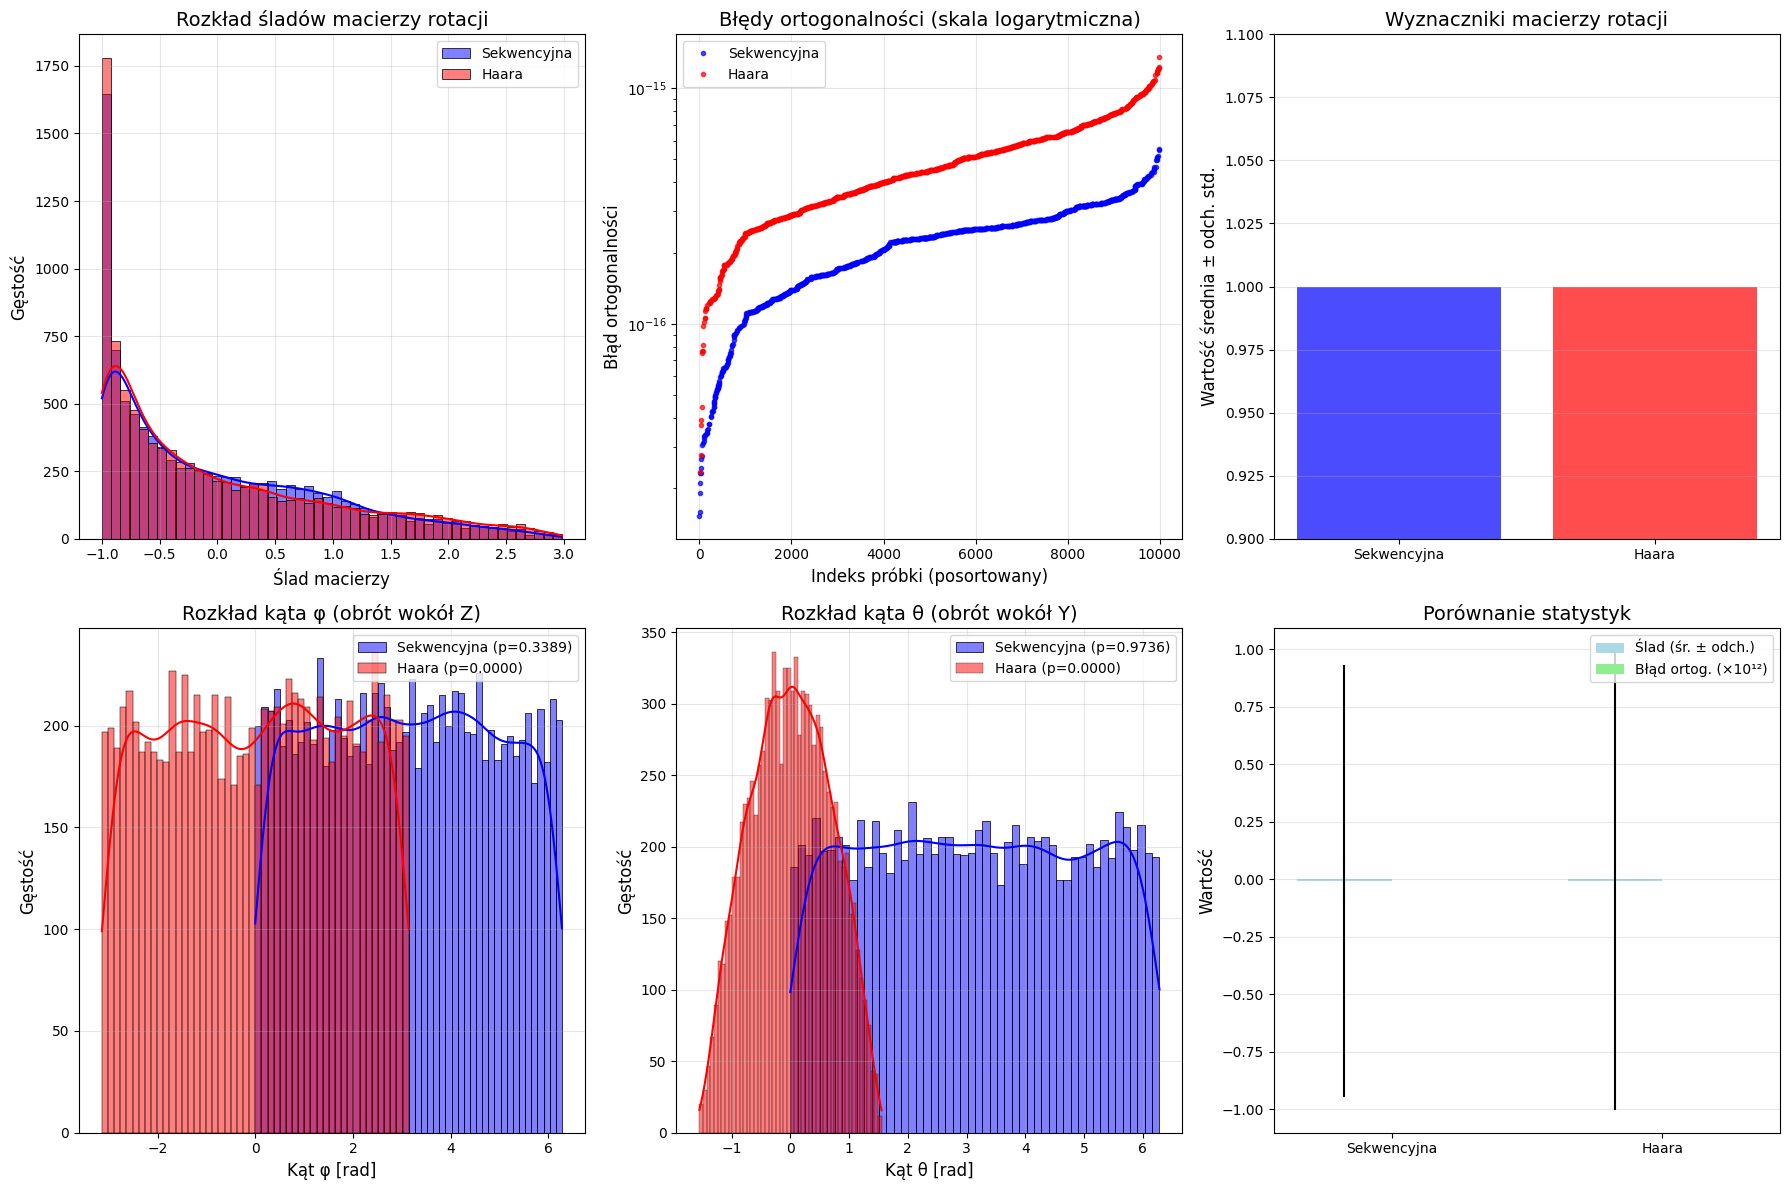


Statystyki rotacji - Sekwencyjna:
Determinants:
  mean: 1.0
  std: 1.5076975831382505e-16
  min: 0.9999999999999994
  max: 1.0000000000000004
Traces:
  mean: -0.006888202477324097
  std: 0.938453562574931
  min: -0.9999999983099637
  max: 2.9760248970445766
Orthogonality_errors:
  mean: 2.210252464271367e-16
  std: 9.498741490124792e-17
  max: 7.154346994122599e-16
Euler_angles:
  phi - test KS p-wartość: 0.338922
  theta - test KS p-wartość: 0.973618
  psi - test KS p-wartość: 0.775314

Statystyki rotacji - Haara:
Determinants:
  mean: 1.0
  std: 2.7396876197226366e-16
  min: 0.9999999999999989
  max: 1.000000000000001
Traces:
  mean: -0.005511856622240397
  std: 0.9969483914503888
  min: -0.9999999736770567
  max: 2.982498819191572
Orthogonality_errors:
  mean: 4.872406388475418e-16
  std: 2.296726812543852e-16
  max: 1.7483114242987771e-15
Euler_angles:
  phi - test KS p-wartość: 0.000000
  theta - test KS p-wartość: 0.000000
  psi - test KS p-wartość: 0.000000


In [ ]:
def generate_sequential_rotation_matrix():
    """
    Generuje macierz rotacji metodą sekwencyjnych obrotów.

    Ta metoda tworzy rotację jako złożenie trzech obrotów wokół osi X, Y i Z
    o losowe kąty z jednolitego rozkładu w zakresie [0, 2π].

    Returns:
        np.ndarray: Macierz rotacji 3x3
    """
    angle_x = np.random.uniform(0, 2*np.pi)
    angle_y = np.random.uniform(0, 2*np.pi)
    angle_z = np.random.uniform(0, 2*np.pi)

    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])

    Ry = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])

    Rz = np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ])

    # Zapisujemy kąty, aby móc je później analizować
    return Rz @ Ry @ Rx, (angle_x, angle_y, angle_z)

def generate_haar_rotation_matrix():
    """
    Generuje macierz rotacji zgodnie z rozkładem Haara.

    Ta metoda wykorzystuje rozkład QR losowej macierzy z rozkładu normalnego,
    a następnie koryguje znak wyznacznika, aby zapewnić, że wynik jest
    macierzą właściwej rotacji (wyznacznik = 1).

    Returns:
        np.ndarray: Macierz rotacji 3x3
    """
    A = np.random.randn(3, 3)
    Q, R = np.linalg.qr(A)

    # Korekta znaku wyznacznika poprzez przemnożenie odpowiednich kolumn
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag

    # Dodatkowa korekta, aby zapewnić wyznacznik = 1
    if np.linalg.det(Q) < 0:
        # Przemnażamy pierwszą kolumnę przez -1, aby zmienić znak wyznacznika
        Q[:, 0] = -Q[:, 0]

    # Ekstrakcja kątów Eulera z macierzy Q
    euler_angles = extract_euler_angles(Q)

    return Q, euler_angles

def extract_euler_angles(R):
    """
    Ekstrahuje kąty Eulera z macierzy rotacji (sekwencja ZYX).

    Args:
        R (np.ndarray): Macierz rotacji 3x3

    Returns:
        tuple: Kąty (phi, theta, psi) w radianach (obroty wokół osi Z, Y, X)
    """
    # Obsługa przypadków skrajnych (gimbal lock)
    if np.abs(R[2, 0]) >= 1.0 - 1e-10:
        # Przypadek ±π/2 dla obrotu wokół osi Y
        phi = np.arctan2(R[0, 1], R[1, 1])
        theta = -np.pi/2 if R[2, 0] > 0 else np.pi/2
        psi = 0.0
    else:
        phi = np.arctan2(R[1, 0], R[0, 0])
        theta = np.arcsin(-R[2, 0])
        psi = np.arctan2(R[2, 1], R[2, 2])

    return (phi, theta, psi)

def analyze_rotation_distribution(generator, num_samples=10000):
    """
    Szczegółowa analiza rozkładu rotacji.

    Args:
        generator: Funkcja generująca macierze rotacji
        num_samples: Liczba próbek do analizy

    Returns:
        dict: Słownik zawierający statystyki rozkładu
    """
    # Generacja macierzy rotacji i ich parametrów
    results = [generator() for _ in range(num_samples)]
    rotations = [r[0] for r in results]
    angles = [r[1] for r in results]

    # Analiza wyznaczników
    determinants = [np.linalg.det(R) for R in rotations]

    # Analiza śladów
    traces = [np.trace(R) for R in rotations]

    # Analiza ortogonalności
    orthogonality_errors = [
        np.linalg.norm(R @ R.T - np.eye(3)) for R in rotations
    ]

    # Analiza kątów - kąty Eulera lub parametry generowania
    if generator.__name__ == 'generate_sequential_rotation_matrix':
        # Dla metody sekwencyjnej: kąty wygenerowane bezpośrednio
        phi_angles = [angle[2] for angle in angles]  # angle_z
        theta_angles = [angle[1] for angle in angles]  # angle_y
        psi_angles = [angle[0] for angle in angles]  # angle_x
    else:
        # Dla metody Haara: kąty Eulera wyekstrahowane z macierzy
        phi_angles = [angle[0] for angle in angles]
        theta_angles = [angle[1] for angle in angles]
        psi_angles = [angle[2] for angle in angles]

    # Test Kołmogorowa-Smirnowa dla kątów (sprawdzenie jednolitości rozkładu)
    # Dla sekwencyjnej metody kąty powinny być jednolite w swoich zakresach
    # Dla metody Haara kąty nie muszą mieć jednolitego rozkładu
    ks_phi = kstest(phi_angles, 'uniform', args=(0, 2*np.pi))
    ks_theta = kstest(theta_angles, 'uniform', args=(0, 2*np.pi) if generator.__name__ == 'generate_sequential_rotation_matrix' else (-np.pi/2, np.pi))
    ks_psi = kstest(psi_angles, 'uniform', args=(0, 2*np.pi))

    return {
        'determinants': {
            'mean': np.mean(determinants),
            'std': np.std(determinants),
            'min': np.min(determinants),
            'max': np.max(determinants)
        },
        'traces': {
            'mean': np.mean(traces),
            'std': np.std(traces),
            'min': np.min(traces),
            'max': np.max(traces),
            'values': traces  # Zachowujemy wszystkie wartości do histogramu
        },
        'orthogonality_errors': {
            'mean': np.mean(orthogonality_errors),
            'std': np.std(orthogonality_errors),
            'max': np.max(orthogonality_errors)
        },
        'euler_angles': {
            'phi': {'values': phi_angles, 'ks_test': ks_phi},
            'theta': {'values': theta_angles, 'ks_test': ks_theta},
            'psi': {'values': psi_angles, 'ks_test': ks_psi}
        }
    }

def visualize_rotation_distributions(num_samples=10000, seed=None):
    """
    Wizualizacja i porównanie rozkładów rotacji.

    Args:
        num_samples (int): Liczba próbek do wygenerowania
        seed (int, optional): Ziarno dla generatora liczb losowych
    """
    if seed is not None:
        np.random.seed(seed)

    # Generatory
    generators = {
        'Sekwencyjna': generate_sequential_rotation_matrix,
        'Haara': generate_haar_rotation_matrix
    }

    # Kolory dla wykresów
    colors = {'Sekwencyjna': 'blue', 'Haara': 'red'}

    # Figura do wizualizacji - zwiększamy rozmiar dla większej czytelności
    plt.figure(figsize=(18, 12))

    # Analiza każdej metody i zapisanie wyników
    stats = {}
    for name, generator in generators.items():
        stats[name] = analyze_rotation_distribution(generator, num_samples)

    # 1. Rozkład śladów - panel 1
    plt.subplot(2, 3, 1)
    for name, color in colors.items():
        sns.histplot(stats[name]['traces']['values'], bins=50, alpha=0.5,
                    color=color, label=name, kde=True)
    plt.title('Rozkład śladów macierzy rotacji', fontsize=14)
    plt.xlabel('Ślad macierzy', fontsize=12)
    plt.ylabel('Gęstość', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # 2. Błędy ortogonalności (wykres logarytmiczny) - panel 2
    plt.subplot(2, 3, 2)
    for name, color in colors.items():
        plt.semilogy(
            np.sort(np.random.choice(range(num_samples), size=min(1000, num_samples), replace=False)),
            np.sort([np.linalg.norm(R @ R.T - np.eye(3)) for R in
                   [generators[name]()[0] for _ in range(min(1000, num_samples))]]),
            'o', markersize=3, color=color, label=name, alpha=0.7
        )
    plt.title('Błędy ortogonalności (skala logarytmiczna)', fontsize=14)
    plt.xlabel('Indeks próbki (posortowany)', fontsize=12)
    plt.ylabel('Błąd ortogonalności', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # 3. Analiza wyznaczników - panel 3
    plt.subplot(2, 3, 3)
    for name, color in colors.items():
        plt.bar(
            name,
            stats[name]['determinants']['mean'],
            yerr=stats[name]['determinants']['std'],
            color=color,
            alpha=0.7
        )
    plt.title('Wyznaczniki macierzy rotacji', fontsize=14)
    plt.ylabel('Wartość średnia ± odch. std.', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0.9, 1.1)  # Powinno być blisko 1

    # 4. Rozkład kątów Eulera (phi) - panel 4
    plt.subplot(2, 3, 4)
    for name, color in colors.items():
        sns.histplot(
            stats[name]['euler_angles']['phi']['values'],
            bins=50,
            alpha=0.5,
            color=color,
            label=f"{name} (p={stats[name]['euler_angles']['phi']['ks_test'].pvalue:.4f})",
            kde=True
        )
    plt.title('Rozkład kąta φ (obrót wokół Z)', fontsize=14)
    plt.xlabel('Kąt φ [rad]', fontsize=12)
    plt.ylabel('Gęstość', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # 5. Rozkład kątów Eulera (theta) - panel 5
    plt.subplot(2, 3, 5)
    for name, color in colors.items():
        sns.histplot(
            stats[name]['euler_angles']['theta']['values'],
            bins=50,
            alpha=0.5,
            color=color,
            label=f"{name} (p={stats[name]['euler_angles']['theta']['ks_test'].pvalue:.4f})",
            kde=True
        )
    plt.title('Rozkład kąta θ (obrót wokół Y)', fontsize=14)
    plt.xlabel('Kąt θ [rad]', fontsize=12)
    plt.ylabel('Gęstość', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # 6. Porównanie statystyk (ślad i błędy ortogonalności) - panel 6
    plt.subplot(2, 3, 6)

    # Przygotowanie danych do wykresu
    stats_data = []
    for name in generators.keys():
        stats_data.append({
            'Method': name,
            'Trace Mean': stats[name]['traces']['mean'],
            'Trace Std': stats[name]['traces']['std'],
            'Ortho Error': stats[name]['orthogonality_errors']['mean']
        })

    # Wykres słupkowy z błędami
    x = np.arange(len(generators))
    width = 0.35

    plt.bar(
        x - width/2,
        [stats_data[i]['Trace Mean'] for i in range(len(stats_data))],
        width,
        yerr=[stats_data[i]['Trace Std'] for i in range(len(stats_data))],
        label='Ślad (śr. ± odch.)',
        color='lightblue'
    )

    plt.bar(
        x + width/2,
        [stats_data[i]['Ortho Error'] * 1e12 for i in range(len(stats_data))],  # Skalowanie dla widoczności
        width,
        label='Błąd ortog. (×10¹²)',
        color='lightgreen'
    )

    plt.xticks(x, [stats_data[i]['Method'] for i in range(len(stats_data))])
    plt.title('Porównanie statystyk', fontsize=14)
    plt.ylabel('Wartość', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Drukowanie szczegółowych statystyk
    for name, generator in generators.items():
        print(f"\nStatystyki rotacji - {name}:")
        for category, values in stats[name].items():
            if category != 'euler_angles':  # Pomijamy kąty Eulera w wydruku dla zwięzłości
                print(f"{category.capitalize()}:")
                for stat, value in values.items():
                    if stat != 'values':  # Nie wypisujemy wszystkich wartości
                        print(f"  {stat}: {value}")
            else:
                print(f"{category.capitalize()}:")
                for angle_name, angle_data in values.items():
                    if 'ks_test' in angle_data:
                        print(f"  {angle_name} - test KS p-wartość: {angle_data['ks_test'].pvalue:.6f}")

if __name__ == "__main__":
    # Uruchomienie analizy
    visualize_rotation_distributions(num_samples=10000, seed=42)

In [ ]:
def generate_haar_rotation_matrix():
    """
    Generuje macierz rotacji zgodnie z rozkładem Haara.

    Ta metoda wykorzystuje rozkład QR losowej macierzy z rozkładu normalnego,
    a następnie koryguje znak wyznacznika, aby zapewnić, że wynik jest
    macierzą właściwej rotacji (wyznacznik = 1).

    Rozkład Haara jest jedynym rozkładem niezmienniczym na grupie obrotów SO(3),
    co oznacza, że zapewnia równomierny rozkład rotacji w przestrzeni.

    Returns:
        np.ndarray: Macierz rotacji 3x3 z równomiernego rozkładu Haara
    """
    # Generujemy losową macierz 3x3 z rozkładu normalnego
    A = np.random.randn(3, 3)

    # Wykonujemy rozkład QR macierzy A
    Q, R = np.linalg.qr(A)

    # Korekta znaku wyznacznika poprzez przemnożenie przez diagonalną macierz
    # zawierającą znaki elementów diagonalnych R
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag

    # Upewniamy się, że macierz ma wyznacznik 1 (jest macierzą rotacji, a nie odbicia)
    if np.linalg.det(Q) < 0:
        # Odwracamy znak pierwszej kolumny, co zmienia znak wyznacznika
        Q[:, 0] = -Q[:, 0]

    return Q

def get_bloch_vector_from_pure_state(psi):
    """
    Oblicza wektor Blocha odpowiadający czystemu stanowi kwantowemu.

    Args:
        psi (np.ndarray): Czysty stan kwantowy jako wektor zespolony [2x1]

    Returns:
        np.ndarray: Wektor Blocha jako wektor 3D
    """
    # Macierze Pauliego
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    # Obliczamy wartości oczekiwane macierzy Pauliego
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]

    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """
    Oblicza czysty stan kwantowy odpowiadający wektorowi Blocha.

    Args:
        r (np.ndarray): Wektor Blocha jako wektor 3D

    Returns:
        np.ndarray: Czysty stan kwantowy jako wektor zespolony [2x1]
    """
    # Normalizacja wektora Blocha (powinien mieć długość 1)
    r = r / np.linalg.norm(r)

    # Konwersja na kąty sferyczne
    theta = np.arccos(r[2])  # Kąt zenitalny (od osi z)
    phi = np.arctan2(r[1], r[0])  # Kąt azymutalny (w płaszczyźnie xy)

    # Stan kwantowy w reprezentacji wektorowej
    psi = np.array([[np.cos(theta/2)],
                    [np.sin(theta/2) * np.exp(1j * phi)]])

    return psi

def get_density_matrix_from_pure_state(psi):
    """
    Oblicza macierz gęstości odpowiadającą czystemu stanowi kwantowemu.

    Args:
        psi (np.ndarray): Czysty stan kwantowy jako wektor zespolony [2x1]

    Returns:
        np.ndarray: Macierz gęstości jako macierz zespolona 2x2
    """
    # Dla czystego stanu |psi⟩, macierz gęstości to |psi⟩⟨psi|
    return psi @ psi.conj().T

def create_canonical_sic_povm():
    """
    Tworzy kanoniczny zestaw SIC-POVM dla kubita.

    Kanoniczny SIC-POVM to tetraedr wpisany w sferę Blocha,
    którego wierzchołki są idealnie równoodległe od siebie.

    Returns:
        list: Lista 4 stanów tworzących dokładny, kanoniczny SIC-POVM
    """
    # Wektory Blocha tworzące idealny tetraedr wpisany w sferę jednostkową
    bloch_vectors = [
        np.array([0, 0, 1]),                     # Północny biegun
        np.array([2*np.sqrt(2)/3, 0, -1/3]),      # Pozostałe trzy wierzchołki tetraedru
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]

    # Konwersja wektorów Blocha na stany kwantowe
    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]

    return sic_povm, bloch_vectors

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """
    Stosuje losową rotację z rozkładu Haara do całego zestawu POVM.

    Args:
        canonical_povm (list): Lista stanów kwantowych
        canonical_bloch_vectors (list, optional): Lista wektorów Blocha

    Returns:
        tuple: Krotka (zrotowany_zestaw, zrotowane_wektory_blocha, macierz_rotacji)
    """
    # Generowanie losowej rotacji z rozkładu Haara
    R = generate_haar_rotation_matrix()

    # Jeśli nie podano wektorów Blocha, obliczamy je
    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]

    # Stosowanie rotacji do każdego wektora Blocha
    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]

    # Konwersja zrotowanych wektorów Blocha z powrotem do stanów kwantowych
    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]

    return rotated_povm, rotated_bloch_vectors, R

def verify_sic_povm(povm_set, bloch_vectors=None, verbose=True):
    """
    Weryfikuje, czy zestaw wektorów tworzy prawidłowy SIC-POVM dla kubita.

    Args:
        povm_set (list): Lista stanów tworzących SIC-POVM
        bloch_vectors (list, optional): Lista wektorów Blocha
        verbose (bool): Czy wyświetlać szczegółowe informacje

    Returns:
        bool: True jeśli zestaw tworzy prawidłowy SIC-POVM, False w przeciwnym przypadku
    """
    # Oczekiwany iloczyn skalarny dla SIC-POVM w wymiarze d=2
    expected_overlap = 1/3

    # Obliczamy wektory Blocha, jeśli nie zostały podane
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]

    # Sprawdzamy wszystkie pary wektorów
    n = len(povm_set)
    max_error = 0

    # Obliczamy iloczyny skalarne stanów kwantowych
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            error = abs(overlap - expected_overlap)
            max_error = max(max_error, error)

    # Obliczamy iloczyny skalarne wektorów Blocha
    bloch_dot_products = []
    for i in range(n):
        for j in range(i+1, n):
            dot_product = np.dot(bloch_vectors[i], bloch_vectors[j])
            bloch_dot_products.append(dot_product)

    # Analizujemy statystyki
    q_overlap_mean = np.mean(quantum_overlaps)
    q_overlap_std = np.std(quantum_overlaps)
    b_dot_mean = np.mean(bloch_dot_products)
    b_dot_std = np.std(bloch_dot_products)

    # Sprawdzamy, czy iloczyny skalarne są wystarczająco bliskie oczekiwanej wartości
    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)

    if verbose:
        print(f"Kwantowe iloczyny skalarne: średnia = {q_overlap_mean:.6f}, odch. std. = {q_overlap_std:.6e}")
        print(f"Iloczyny skalarne Blocha: średnia = {b_dot_mean:.6f}, odch. std. = {b_dot_std:.6e}")
        print(f"Maksymalny błąd kwantowego iloczynu skalarnego: {max_error:.6e}")
        print(f"Czy zestaw jest prawidłowym SIC-POVM: {is_valid}")

    return is_valid

def create_sic_povm_plotly_visualization(canonical_bloch_vectors, rotated_bloch_vectors, rotation_matrix, selected_vector_index=None):
    """
    Tworzy interaktywną wizualizację Plotly zestawu SIC-POVM na sferze Blocha.

    Args:
        canonical_bloch_vectors (list): Lista wektorów Blocha kanonicznego zestawu
        rotated_bloch_vectors (list): Lista wektorów Blocha zrotowanego zestawu
        rotation_matrix (np.ndarray): Macierz rotacji SO(3)
        selected_vector_index (int, optional): Indeks wybranego wektora do wyróżnienia

    Returns:
        plotly.graph_objects.Figure: Figura Plotly
    """
    # Losowe wybranie jednego wektora, jeśli nie został określony
    if selected_vector_index is None:
        selected_vector_index = random.randint(0, 3)
    elif selected_vector_index >= 4:
        selected_vector_index = 0

    # Pobieranie wybranego wektora
    selected_canonical_vector = canonical_bloch_vectors[selected_vector_index]
    selected_rotated_vector = rotated_bloch_vectors[selected_vector_index]

    # Tworzenie figury Plotly
    fig = go.Figure()

    # Powierzchnia sfery Blocha
    phi_grid = np.linspace(0, 2*np.pi, 100)
    theta_grid = np.linspace(0, np.pi, 50)
    phi_mesh, theta_mesh = np.meshgrid(phi_grid, theta_grid)

    x_sphere = np.sin(theta_mesh) * np.cos(phi_mesh)
    y_sphere = np.sin(theta_mesh) * np.sin(phi_mesh)
    z_sphere = np.cos(theta_mesh)

    fig.add_trace(go.Surface(
        x=x_sphere,
        y=y_sphere,
        z=z_sphere,
        colorscale=[[0, 'rgba(240, 240, 240, 0.2)'], [1, 'rgba(240, 240, 240, 0.2)']],
        showscale=False,
        name='Sfera Blocha'
    ))

    # Osie współrzędnych
    axis_length = 1.2
    axis_colors = ['red', 'green', 'blue']
    axis_labels = ['X', 'Y', 'Z']
    axis_coords = [
        ([-axis_length, axis_length], [0, 0], [0, 0]),
        ([0, 0], [-axis_length, axis_length], [0, 0]),
        ([0, 0], [0, 0], [-axis_length, axis_length])
    ]

    for (x_line, y_line, z_line), color, label in zip(axis_coords, axis_colors, axis_labels):
        fig.add_trace(go.Scatter3d(
            x=x_line, y=y_line, z=z_line,
            mode='lines',
            line=dict(color=color, width=4),
            name=f'Oś {label}'
        ))

    # Wizualizacja zestawów POVM
    povm_sets = [canonical_bloch_vectors, rotated_bloch_vectors]
    povm_colors = ['blue', 'red']
    povm_names = ['Kanoniczny POVM', 'Zrotowany POVM']

    for povms, color, name in zip(povm_sets, povm_colors, povm_names):
        # Rysowanie krawędzi tetraedru
        for i in range(4):
            for j in range(i+1, 4):
                fig.add_trace(go.Scatter3d(
                    x=[povms[i][0], povms[j][0]],
                    y=[povms[i][1], povms[j][1]],
                    z=[povms[i][2], povms[j][2]],
                    mode='lines',
                    line=dict(color=color, width=2, dash='dot'),
                    name=f'{name} Krawędź'
                ))

        # Dodawanie wierzchołków POVM
        for k, vec in enumerate(povms):
            # Sprawdzenie, czy to wybrany wektor
            is_selected = (k == selected_vector_index)
            marker_size = 10 if not is_selected else 15
            symbol = 'diamond' if not is_selected else 'diamond-open'
            opacity = 0.7 if not is_selected else 1.0
            line_width = 2 if not is_selected else 3

            fig.add_trace(go.Scatter3d(
                x=[vec[0]], y=[vec[1]], z=[vec[2]],
                mode='markers+text',
                marker=dict(
                    size=marker_size,
                    color=color,
                    symbol=symbol,
                    opacity=opacity,
                    line=dict(color='black', width=line_width)
                ),
                text=[f'{name} {k+1}{"*" if is_selected else ""}'],
                textposition="top center",
                name=f'{name} Wektor {k+1}{"*" if is_selected else ""}'
            ))

    # Dodanie strzałki transformacji dla wybranego wektora
    fig.add_trace(go.Scatter3d(
        x=[selected_canonical_vector[0], selected_rotated_vector[0]],
        y=[selected_canonical_vector[1], selected_rotated_vector[1]],
        z=[selected_canonical_vector[2], selected_rotated_vector[2]],
        mode='lines',
        line=dict(color='purple', width=5, dash='dashdot'),
        name='Transformacja wybranego wektora'
    ))

    # Konfiguracja układu
    fig.update_layout(
        title=f'Wizualizacja rotacji SIC-POVM (Wybrany wektor: {selected_vector_index+1})',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14
        )
    )

    # Dodanie adnotacji z informacjami o wybranym wektorze i macierzy rotacji
    fig.add_annotation(
        x=1.0,
        y=0.0,
        xref="paper",
        yref="paper",
        text=f"<b>Wybrany wektor {selected_vector_index+1}</b><br>" +
             f"Kanoniczny: [{selected_canonical_vector[0]:.4f}, {selected_canonical_vector[1]:.4f}, {selected_canonical_vector[2]:.4f}]<br>" +
             f"Zrotowany: [{selected_rotated_vector[0]:.4f}, {selected_rotated_vector[1]:.4f}, {selected_rotated_vector[2]:.4f}]<br><br>" +
             f"<b>Macierz rotacji SO(3)</b><br>" +
             f"[{rotation_matrix[0,0]:.4f}, {rotation_matrix[0,1]:.4f}, {rotation_matrix[0,2]:.4f}]<br>" +
             f"[{rotation_matrix[1,0]:.4f}, {rotation_matrix[1,1]:.4f}, {rotation_matrix[1,2]:.4f}]<br>" +
             f"[{rotation_matrix[2,0]:.4f}, {rotation_matrix[2,1]:.4f}, {rotation_matrix[2,2]:.4f}]",
        showarrow=False,
        bordercolor="black",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
    )

    return fig

def run_sic_povm_generator(num_sets=1, seed=None, visualize=True, selected_vector=None):
    """
    Funkcja główna do używania w środowisku Colab lub w interaktywnych notatnikach.

    Args:
        num_sets (int): Liczba zestawów SIC-POVM do wygenerowania
        seed (int, optional): Ziarno dla generatora liczb losowych
        visualize (bool): Czy wygenerować interaktywną wizualizację
        selected_vector (int, optional): Indeks wybranego wektora do wizualizacji

    Returns:
        tuple: Krotka (wygenerowane_zestawy, figury_plotly)
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Tworzenie kanonicznego zestawu SIC-POVM
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()

    print("Kanoniczny zestaw SIC-POVM:")
    verify_sic_povm(canonical_povm, canonical_bloch_vectors)

    # Lista przechowująca wszystkie wygenerowane zestawy
    all_povm_sets = []
    plotly_figures = []

    for i in range(num_sets):
        print(f"\nGenerowanie zestawu SIC-POVM #{i+1}:")

        # Stosowanie losowej rotacji z rozkładu Haara do kanonicznego zestawu
        rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors)

        # Weryfikacja zestawu
        is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

        if is_valid:
            # Dodanie do listy wygenerowanych zestawów
            all_povm_sets.append((rotated_povm, rotated_bloch_vectors, rotation_matrix))

            # Drukowanie macierzy rotacji
            print("\nMacierz rotacji SO(3):")
            for row in rotation_matrix:
                print(f"[{row[0]:.6f}, {row[1]:.6f}, {row[2]:.6f}]")

            # Tworzenie wizualizacji Plotly
            if visualize:
                fig = create_sic_povm_plotly_visualization(
                    canonical_bloch_vectors,
                    rotated_bloch_vectors,
                    rotation_matrix,
                    selected_vector
                )
                plotly_figures.append(fig)

                # Wyświetlenie figury, jeśli to pierwszy zestaw
                if i == 0:
                    fig.show()
        else:
            print("Uwaga: Wygenerowany zestaw nie spełnia warunków SIC-POVM!")

    print(f"\nWygenerowano {len(all_povm_sets)} prawidłowych zestawów SIC-POVM z {num_sets} prób.")

    return all_povm_sets, plotly_figures

def choose_random_vector_visualization(povm_sets, set_index=0):
    """
    Tworzy nową wizualizację z losowo wybranym wektorem.

    Args:
        povm_sets (list): Lista wygenerowanych zestawów SIC-POVM
        set_index (int): Indeks zestawu do wizualizacji

    Returns:
        plotly.graph_objects.Figure: Nowa figura Plotly
    """
    if not povm_sets or set_index >= len(povm_sets):
        print("Brak dostępnych zestawów SIC-POVM!")
        return None

    # Losowy wybór wektora
    selected_vector = random.randint(0, 3)

    # Pobieranie danych zestawu
    _, rotated_bloch_vectors, rotation_matrix = povm_sets[set_index]

    # Tworzenie kanonicznego zestawu
    _, canonical_bloch_vectors = create_canonical_sic_povm()

    # Tworzenie nowej wizualizacji
    fig = create_sic_povm_plotly_visualization(
        canonical_bloch_vectors,
        rotated_bloch_vectors,
        rotation_matrix,
        selected_vector
    )

    print(f"Utworzono nową wizualizację z wybranym wektorem {selected_vector+1}")

    # Wyświetlenie figury
    fig.show()

    return fig

# Przykład użycia:
# povm_sets, figures = run_sic_povm_generator(num_sets=2, seed=42)
# choose_random_vector_visualization(povm_sets, 0)  # Nowa wizualizacja z losowym wektorem

In [ ]:
povm_sets = run_sic_povm_generator(num_sets=40, seed=50, visualize=True)

Kanoniczny zestaw SIC-POVM:
Kwantowe iloczyny skalarne: średnia = 0.333333, odch. std. = 1.013490e-16
Iloczyny skalarne Blocha: średnia = -0.333333, odch. std. = 9.343919e-17
Maksymalny błąd kwantowego iloczynu skalarnego: 1.665335e-16
Czy zestaw jest prawidłowym SIC-POVM: True

Generowanie zestawu SIC-POVM #1:
Kwantowe iloczyny skalarne: średnia = 0.333333, odch. std. = 1.725912e-16
Iloczyny skalarne Blocha: średnia = -0.333333, odch. std. = 2.014272e-16
Maksymalny błąd kwantowego iloczynu skalarnego: 3.885781e-16
Czy zestaw jest prawidłowym SIC-POVM: True

Macierz rotacji SO(3):
[-0.684996, -0.710047, -0.163135]
[-0.642952, 0.483862, 0.593709]
[-0.342627, 0.511576, -0.787970]



Generowanie zestawu SIC-POVM #2:
Kwantowe iloczyny skalarne: średnia = 0.333333, odch. std. = 1.241267e-16
Iloczyny skalarne Blocha: średnia = -0.333333, odch. std. = 1.359740e-16
Maksymalny błąd kwantowego iloczynu skalarnego: 1.665335e-16
Czy zestaw jest prawidłowym SIC-POVM: True

Macierz rotacji SO(3):
[0.605647, 0.598303, -0.524619]
[-0.317878, -0.422485, -0.848799]
[-0.729483, 0.680837, -0.065689]

Generowanie zestawu SIC-POVM #3:
Kwantowe iloczyny skalarne: średnia = 0.333333, odch. std. = 1.220404e-16
Iloczyny skalarne Blocha: średnia = -0.333333, odch. std. = 1.133117e-16
Maksymalny błąd kwantowego iloczynu skalarnego: 2.220446e-16
Czy zestaw jest prawidłowym SIC-POVM: True

Macierz rotacji SO(3):
[-0.519959, 0.695792, -0.495495]
[-0.621753, -0.706045, -0.339004]
[-0.585718, 0.131807, 0.799726]

Generowanie zestawu SIC-POVM #4:
Kwantowe iloczyny skalarne: średnia = 0.333333, odch. std. = 8.171020e-17
Iloczyny skalarne Blocha: średnia = -0.333333, odch. std. = 1.468687e-16
Mak